# **Face Expression Classification Using CNN**

**Import Libraries**

In [6]:
import torch
from torch import nn;
from torch.utils.data import Dataset, DataLoader;
from torchvision.transforms import ToTensor, RandomResizedCrop, RandomHorizontalFlip, RandomVerticalFlip;
import matplotlib.pyplot as plt;
import glob;
from PIL import Image
import numpy;
import matplotlib.pyplot as plt;
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report;
import os


**Load Dataset**

In [9]:
# Modify the glob pattern to find files in subdirectories
for index, val in enumerate(glob.glob("./images/train/*")):
    normalized_path = os.path.normpath(val)
    split_path = normalized_path.split(os.path.sep)
    
    # This step ensures we capture the emotion type from the folder names
    if len(split_path) > 2:  # Adjusting to handle folder names at index 2
        outputType[split_path[-1]] = index  # Use the last part of the path for emotion type
    else:
        print(f"Path {val} does not have the expected structure")

class LoadData(Dataset):
    def __init__(self, isTrain=True):
        self.isTrain = isTrain
        dataType = "train" if isTrain else "validation"
        
        # Update glob pattern to search for files inside emotion subdirectories
        self.pathFile = glob.glob(f"./images/{dataType}/*/*")
        
        if isTrain:
            tempData = []
            for i in range(9):
                self.pathFile += glob.glob(f"./images/{dataType}/disgust/*")
                
            for type in outputType:
                cnt = 0
                for path in self.pathFile:
                    normalized_path = os.path.normpath(path)
                    split_path = normalized_path.split(os.path.sep)
                    if len(split_path) > 3 and split_path[-2] == type and cnt <= 7000:
                        cnt += 1
                        tempData.append(path)
                        countType[outputType[type]] += 1
                        
            self.pathFile = tempData
        
        self.transform = ToTensor()
        self.dataAug = nn.Sequential(
            RandomResizedCrop((48, 48), scale=(0.8, 1), ratio=(0.5, 2)),
            RandomHorizontalFlip(),
            RandomVerticalFlip()
        )

    def __len__(self):
        return len(self.pathFile)

    def __getitem__(self, index):
        imgPath = self.pathFile[index]
        img = Image.open(imgPath)
        normalized_path = os.path.normpath(imgPath)
        split_path = normalized_path.split(os.path.sep)
        # Access the emotion type from the second-to-last folder name
        label = outputType[split_path[-2]] if len(split_path) > 3 else -1
        img = self.transform(img)
        if self.isTrain:
            img = self.dataAug(img)
        items = (img, label)
        return items


In [10]:
trainData = LoadData(isTrain = True);
for key, val in enumerate(outputType):
    print(val, countType[key]);
validationData = LoadData(isTrain = False);
trainDataLoader = DataLoader(trainData, batch_size=64, shuffle=True);
validationDataLoader = DataLoader(validationData, batch_size=64, shuffle=True);


angry 3993
disgust 4360
fear 4103
happy 7001
neutral 4982
sad 4938
surprise 3205


**Define Model**

In [11]:
class Residual(nn.Module):
    def __init__(self, inputChannels, outputChannels):
        super().__init__();
        self.block = nn.Sequential(
            nn.Conv2d(inputChannels, outputChannels, 3, padding = 1),
            nn.BatchNorm2d(outputChannels),
            nn.ReLU(),
            nn.Dropout(p = 0.25),
            nn.Conv2d(outputChannels, outputChannels, 3, padding = 1),
            nn.BatchNorm2d(outputChannels)
        )
        self.resize = nn.Conv2d(inputChannels, outputChannels, 1);
    def forward(self, x):
        return nn.Dropout(p = 0.25)(nn.ReLU()(self.block(x) + self.resize(x)));


In [12]:
class MyModels(nn.Module):
    def __init__(self):
        super().__init__();
        self.neutralNetwork = nn.Sequential(
            
            nn.Conv2d(1, 64, 5, padding = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2, padding = 1),
            nn.Dropout(p = 0.25),
            
            Residual(64, 128),
            Residual(128, 256),
            Residual(256, 512),
            Residual(512, 512),
            
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(512, 7),
            nn.Softmax(dim = 1)
        );
    def forward(self, x):
        return self.neutralNetwork(x);


**Define Parameters and Enable GPU**

In [13]:
learningRate = 2.5e-4


In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = MyModels().to(device);
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)


**Define Train Function**

In [15]:
def train(dataloader, model, lossFunction, optimizer):
    size = len(dataloader.dataset)
    model.train();
    for batch, (X, y) in enumerate(dataloader):
        predict = model(X.to(device));
        loss = lossFunction(predict, y.to(device));
        
        loss.backward();
        optimizer.step();
        optimizer.zero_grad();
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss} [{current}/{size}]");


**Define Test Function**

In [16]:
def test(dataloader, model, lossFunction):
    size = len(dataloader.dataset)
    model.eval();
    #size of the whole testdata
    size = len(dataloader.dataset)
    #number of batches
    numBatches = len(dataloader)
    testLoss, correct = 0, 0
       
    with torch.no_grad():
        for X, y in dataloader:
            predict = model(X.to(device))
            testLoss += lossFunction(predict, y.to(device)).item()
            correct += (predict.argmax(1) == y.to(device)).type(torch.float).sum().item()
        
        testLoss /= numBatches;
        correct /= size;
        print(f"Test Error: Accuracy: {100 * correct}%, Avg loss: {testLoss} \n");


**Train Model**

In [19]:
epochs = 100;
for t in range(epochs):
    print(f"Epoch {t + 1}\n -------------------------------");
    train(trainDataLoader, model, lossFunction, optimizer);
    test(validationDataLoader, model, lossFunction);


Epoch 1
 -------------------------------
loss: 1.9269858598709106 [64/32582]
loss: 1.9246209859848022 [6464/32582]
loss: 1.8933602571487427 [12864/32582]
loss: 1.8789335489273071 [19264/32582]
loss: 1.7466579675674438 [25664/32582]
loss: 1.8088799715042114 [32064/32582]
Test Error: Accuracy: 27.56863855080668%, Avg loss: 1.8774708058383014 

Epoch 2
 -------------------------------
loss: 1.797829508781433 [64/32582]
loss: 1.7884687185287476 [6464/32582]
loss: 1.8570713996887207 [12864/32582]
loss: 1.7650877237319946 [19264/32582]
loss: 1.8558433055877686 [25664/32582]
loss: 1.793834924697876 [32064/32582]
Test Error: Accuracy: 29.847155392018117%, Avg loss: 1.8577033850523803 

Epoch 3
 -------------------------------
loss: 1.8159945011138916 [64/32582]
loss: 1.7935705184936523 [6464/32582]
loss: 1.769644021987915 [12864/32582]
loss: 1.789390206336975 [19264/32582]
loss: 1.751638412475586 [25664/32582]
loss: 1.7981493473052979 [32064/32582]
Test Error: Accuracy: 34.06453439003679%, Avg

**Visualize Confusion Matrix**

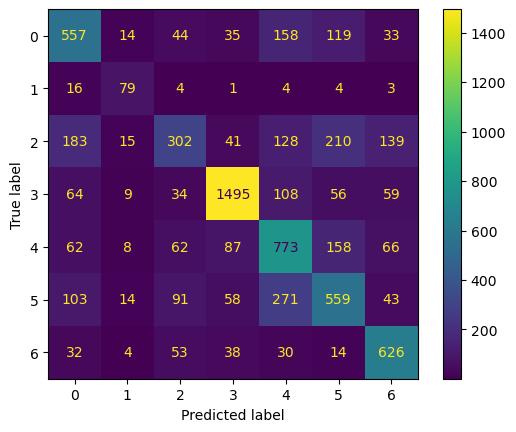

In [20]:
y = numpy.array([])
predict = numpy.array([])
with torch.no_grad():
    for (X_, y_) in validationDataLoader:
        predict = numpy.concatenate([predict, numpy.array(torch.Tensor.cpu(model(X_.to(device)))).argmax(1)]);
        y = numpy.concatenate([y, numpy.array(y_)]);
cm = confusion_matrix(y, predict);
ConfusionMatrixDisplay(cm).plot()


**Evaluate Model**

In [21]:
print(classification_report(y, predict, target_names = outputType));


              precision    recall  f1-score   support

       angry       0.55      0.58      0.56       960
     disgust       0.55      0.71      0.62       111
        fear       0.51      0.30      0.38      1018
       happy       0.85      0.82      0.84      1825
     neutral       0.53      0.64      0.58      1216
         sad       0.50      0.49      0.49      1139
    surprise       0.65      0.79      0.71       797

    accuracy                           0.62      7066
   macro avg       0.59      0.62      0.60      7066
weighted avg       0.62      0.62      0.61      7066



**Save Model**

In [22]:
torch.save(model, "myFirstModel.pth")
